INTRODUCTION

There are numerous sources of energy in nature, and they are primarily divided into two parts, namely renewable and nonrenewable sources. Solar energy is one kind of renewable energy that is found in nature in plentiful amounts. In solar power plants, the radiation that comes from the sun is turned into electricity. Since they have an unlimited source and it is clean energy, solar energy plants are becoming very popular day by day due to their sustainable and eco-friendly nature [1].

Solar power forecasting is substantial since the possible electricity generation of the plant is used to adjust the battery storage capacity efficiently. In order to optimize the plant to maximize both energy production and income, forecasting methods are used. This project aims to forecast the hourly solar power of the Edikli GES for the next day. The solar power plant is located between 37.75-38.75° north latitude and 34.5 -35.5° east longitude. The production data for the previous periods of the plant are given. Also, the weather information data for 25 coordinates is given to be used as variables in this forecasting task. Using these data, a 24-hour forecast for the production of the next day is made for 14 consecutive days starting from 13 May 2024.

Throughout the project, mainly the Linear Regression and Machine Learning models will be used for forecasting to determine the best model that works for solar power production, after the descriptive analysis of the data is performed.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error

# Load data
weather_data = pd.read_csv('processed_weather.csv')
production_data = pd.read_csv('production.csv')


# Display column names for inspection
weather_columns = weather_data.columns
production_columns = production_data.columns

weather_columns, production_columns


After the necessary packages are imported, it is started to conduct the descriptive analysis of the data. The provided data for the weather information is in a long format. However, firstly, they are reshaped and converted to a wide format. In this way, 25 possible predictor variables which can be used in the forecast model become 250. Also, no additional data manipulation is made for the production data. Then, the wide format weather data and production data are merged.

In [2]:
# Combine date and hour to create datetime column
weather_data['datetime'] = pd.to_datetime(weather_data['date']) + pd.to_timedelta(weather_data['hour'], unit='h')
production_data['datetime'] = pd.to_datetime(production_data['date']) + pd.to_timedelta(production_data['hour'], unit='h')

# Drop original date and hour columns
weather_data.drop(columns=['date', 'hour'], inplace=True)
production_data.drop(columns=['date', 'hour'], inplace=True)

# Data Preprocessing
# Reshape weather data from long format to wide format
weather_data_wide = weather_data.pivot_table(
    index=['datetime'],
    columns=['lat', 'lon'],
    values=['dswrf_surface', 'uswrf_surface', 'dlwrf_surface', 'tcdc_low.cloud.layer', 
            'tcdc_middle.cloud.layer', 'tcdc_high.cloud.layer', 'tcdc_entire.atmosphere', 
            'csnow_surface', 'tmp_surface']
)
weather_data_wide.columns = [f"{var}_{lat}_{lon}" for var, lat, lon in weather_data_wide.columns]
weather_data_wide.reset_index(inplace=True)


# Merge with production data
data = pd.merge(production_data, weather_data_wide, on='datetime')

# Add time-based features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

# Save the datetime column for later use
datetime_index = data['datetime']

# Drop the datetime column for training
data.drop(columns=['datetime'], inplace=True)

Before it is started to construct a regression model, the solar power production time series is plotted. The plot is provided below. As it is seen, production is higher in the months between July and October. Therefore, it could be said that the data has seasonality and the mean of the data is higher in the summer season. Since the data is only for one year, no upward or downward trend is observed through the year.

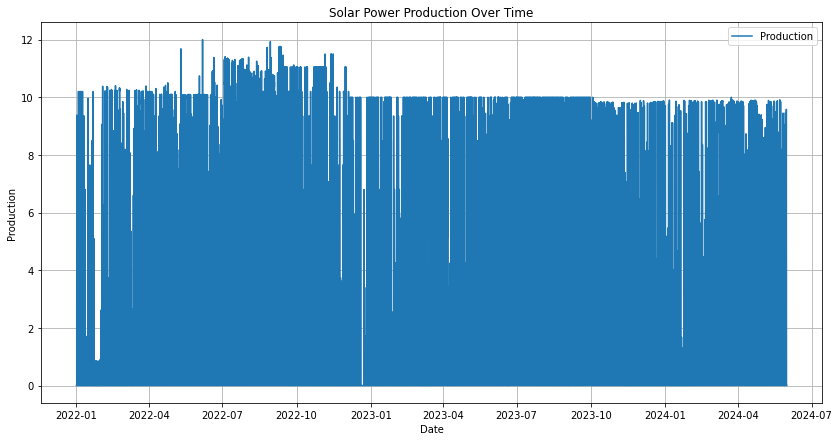

In [3]:

# Exploratory Data Analysis
# Time series plot of production data
plt.figure(figsize=(14, 7))
plt.plot(production_data['datetime'], production_data['production'], label='Production')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Solar Power Production Over Time')
plt.legend()
plt.grid(True)
plt.show()

After the time plot of the data is observed, the correlations between the possible predictor variables, which are the weather variables and the production data, are evaluated. In general terms, correlation is the linear relationship between two variables. A correlation coefficient is calculated to see the degree of correlation and it ranges from -1 to 1. -1 shows perfect negative correlation, 1 shows perfect positive correlation and 0 means no correlation.

In the plot below, all possible predictors are plotted against each other and the correlation between them is calculated. The red in the plot represents a strong positive correlation. When the correlation between two or more predictor variables is high, they provide similar information, and this phenomenon is named multicollinearity. Multicollinearity should be carefully investigated since if the correlation coefficient between variables is 1 or -1, the regression model cannot be estimated. Therefore, the predictors that have perfect correlation should be eliminated accordingly.

In the second plot, the distribution of the data is evaluated by creating a histogram of the data. Other than 0, all other production data have similar frequencies.

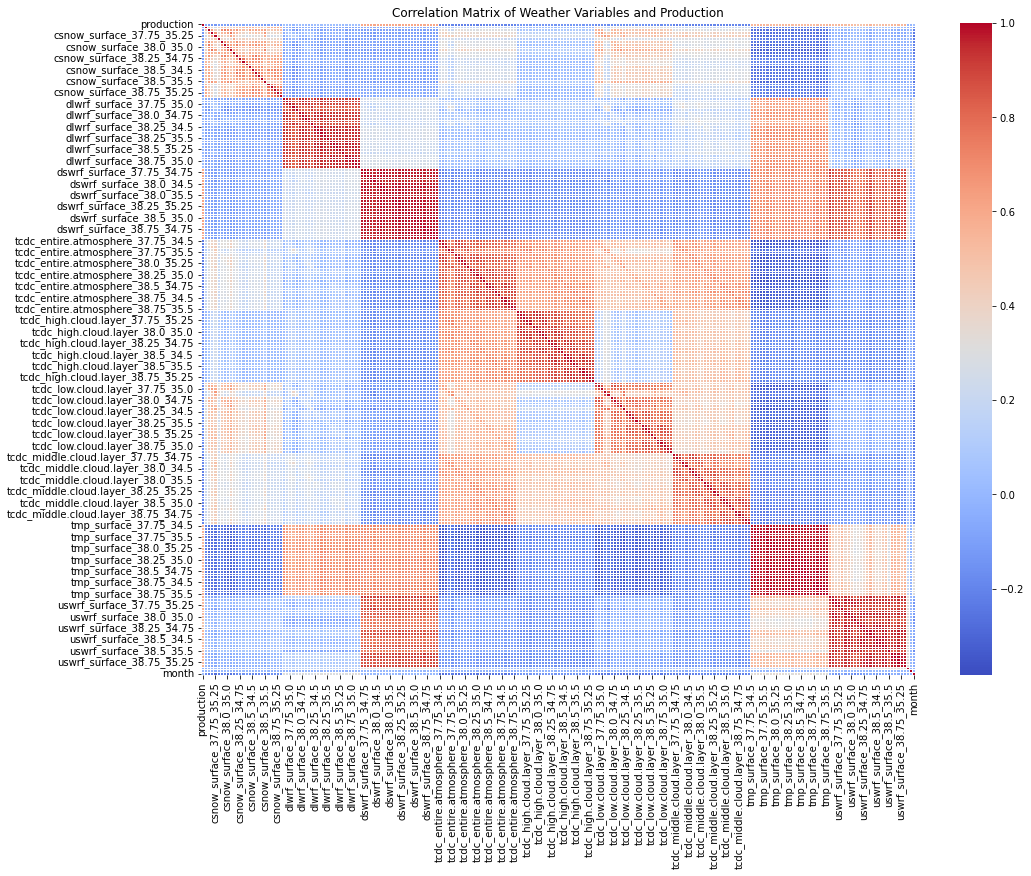

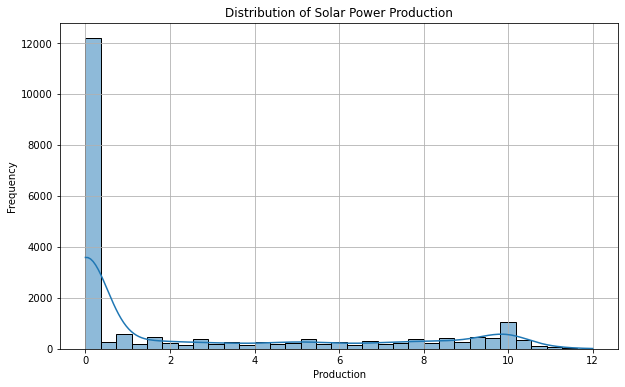

In [4]:
# Correlation heatmap
corr_matrix = data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables and Production')
plt.show()

# Distribution of production
plt.figure(figsize=(10, 6))
sns.histplot(data['production'], kde=True)
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title('Distribution of Solar Power Production')
plt.grid(True)
plt.show()


RELATED LITERATURE

Solar forecasting methods can be divided into three main parts. Physical methods use satellite data and weather information to simulate the behavior of weather, sunlight, cloud coverage, etc. to forecast the power generation of the plant. Statistical methods use historical energy production data and statistically manipulate it to predict production in the near future by also trying to maintain the patterns that exist in the historical data in hand. As a third type of methodology, the holistic and integral methods can be used. These methods integrate external information such as weather predictions with real-time data like rooftop energy production or current battery status and try to operate the system continuously [2]. Lots of different models are constructed for solar forecasting and they can be seen in the literature. For instance, the Gautier-Diak-Masse (GDM) Model, which is a physical satellite model was constructed in 1980. The model uses geostationary satellite data and images to consider cloud variability. The model is divided into clear-air and cloudy-atmosphere models. As a result of their study, they show that the variations in the insolation are represented accurately by the variations in the satellite estimates [3]. Other than the physical models, the statistical models constructed by scientists are found in the literature. Time series models use the historical data and the patterns that the data have. For instance, Moving Average (MA) Models find output by using white noise of the data as input and model the data by using the past forecast errors in the model. Additionally, the Auto-Regressive Integrated Moving Average Models (ARIMA) are used for forecasting. The model is the combination of differencing with the moving average model and autoregression [4]. In the paper written by Atique et al., the ARIMA model is used to forecast solar energy generation daily. After converting the seasonal and nonstationary solar energy generation data in hand to stationary time series, the ARIMA model is applied, and its accuracy is discussed [5].

APPROACH

In order to forecast solar power production, the Linear Regression Model and some Machine Learning Models are utilized throughout the project. Before constructing a model, data reprocessing is done, and the data is prepared for analysis. However, no transformation or smoothing is needed for the proposed models in the project. Then, for each selected model, models are trained and then their forecast accuracy is evaluated. Also, all models are compared against each other in terms of forecast accuracy.

Before constructing any forecast model, the data is split into two parts training and test sets. Generally, 20% of the data is allocated for the test set. The training data is used to construct the model, then, the forecasting accuracy of the model is investigated using the test data.

In the code block below, the rows in the data that have missing values are dropped to avoid any complication that may arise in the forecast model-building process.

In [5]:
# Feature Engineering
# Create lag features
for lag in range(1, 49):
    data[f'production_lag_{lag}'] = data['production'].shift(lag)

# Drop rows with missing values
data.dropna(inplace=True)

In [6]:
# Split data into training and testing sets
X = data.drop(columns=['production'])
y = data['production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In this project, the forecast of solar power prediction is first made with the linear regression model. Training data is used for model fit. The linear regression model is one of the basic statistical methods that could be used for forecasting. The model captures the linear relationship between predictor and forecast variables. The coefficients of the model are calculated so that the sum of squared errors between fitted values and observations is minimized.

In [1]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

NameError: name 'LinearRegression' is not defined

Then, the random forest model is constructed as the second method. In general terms, that model brings together the predictions of multiple decision trees so that it can produce highly accurate forecasts. It is an ensemble technique that can capture both non-linear and linear relationships in the data. It basically uses multiple decision trees that work on subsets of data and it finally merges the forecasts of these trees.

In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


After the two models, Linear Regression and Random Forest Models, are built, their forecast accuracy is compared in terms of MAPE, Mean Absolute Percentage Error. Instead of MAPE, scale-dependent errors such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSR) could be used. MAPE, however, has the advantage of being a unitless error measure. Therefore, it is widely used to compare different forecasting methods.

Additionally, a baseline model is constructed as a reference point for the comparisons of different models. The baseline method predictions are generated by shifting the data 48 periods before, as done by the code. It means that the production data 48 period before is taken as the baseline forecast.

In [9]:
# Evaluation
lr_mape = mean_absolute_percentage_error(y_test, lr_predictions)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

# Baseline Method
baseline_predictions = data['production'].shift(48).iloc[-len(y_test):]
baseline_mape = mean_absolute_percentage_error(y_test, baseline_predictions)

In order to visualize the forecasting accuracy of each of the three models, test data is used. How accurate linear regression, random forecast, and baseline models predict the test data can be seen in the plot below. When the MAPE of each model is printed, the smallest MAPE is obtained from the Random Forest Model, which indicates that the most successful model to predict solar power production is the Random Forest Model and it is expected.

The accuracy of the Random Forecast Model is higher since unless Linear Regression, it can capture both linear and nonlinear relations in the data. Also, it is the better model when the dataset is larger and lots of possible predictor variables exist, like in the case of the project. However, it has some drawbacks too. For instance, it has a higher tendency to overfit the model and its interpretation is harder.

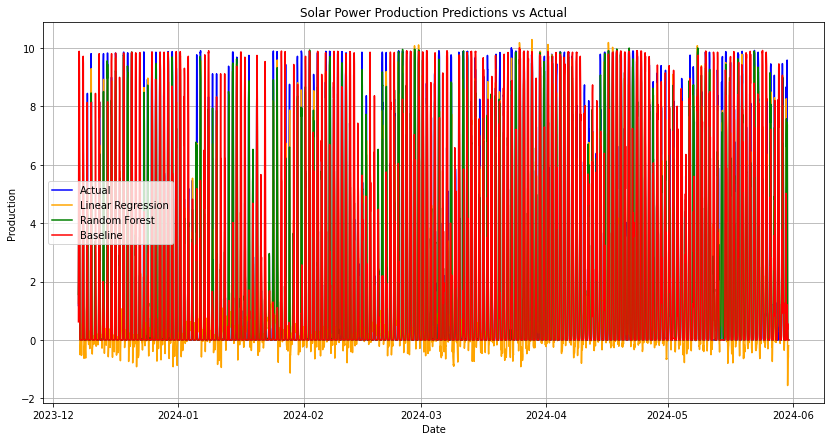

Linear Regression MAPE: 631308243126807.4
Random Forest MAPE: 63626667574017.17
Baseline MAPE: 123541950413616.77


In [10]:
# Results Visualization
plt.figure(figsize=(14, 7))
plt.plot(datetime_index.iloc[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(datetime_index.iloc[-len(y_test):], lr_predictions, label='Linear Regression', color='orange')
plt.plot(datetime_index.iloc[-len(y_test):], rf_predictions, label='Random Forest', color='green')
plt.plot(datetime_index.iloc[-len(y_test):], baseline_predictions, label='Baseline', color='red')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Solar Power Production Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()


# Print MAPE values
print(f"Linear Regression MAPE: {lr_mape}")
print(f"Random Forest MAPE: {rf_mape}")
print(f"Baseline MAPE: {baseline_mape}")


One of the crucial steps of evaluation of the linear regression model is to make a residual analysis. The model assumes that the residuals are not autocorrelated and have mean zero. To see whether these assumptions are satisfied or not, the plot of residuals with respect to time and the ACF plot of the residuals are used. The plot of residuals over time looks very similar to the white noise series: it has mean zero, constant variation, and also does not have any trend or seasonality. Considering this plot, it could be said that the residuals of the linear regression model satisfies the necessary assumptions.

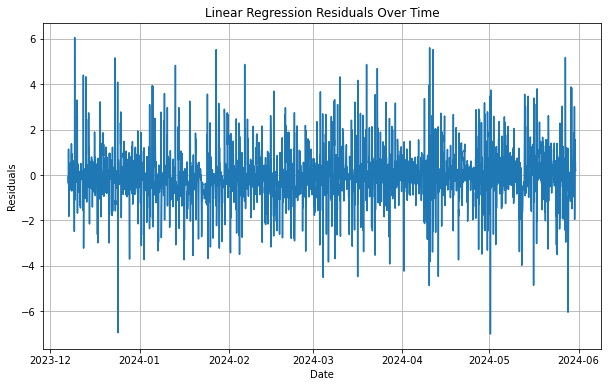

In [11]:
# Residual Analysis for Linear Regression
lr_residuals = y_test - lr_predictions
plt.figure(figsize=(10, 6))
plt.plot(production_data['datetime'].iloc[-len(y_test):], lr_residuals)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Linear Regression Residuals Over Time')
plt.grid(True)
plt.show()

In the ACF plot below, it could be visually checked whether there is significant autocorrelation or not. If there are spikes that exceed the limits, one can say the residuals are autocorrelated.

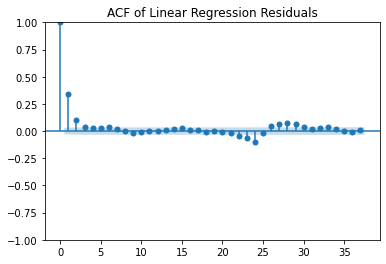

In [12]:
# ACF of residuals


plot_acf(lr_residuals)
plt.title('ACF of Linear Regression Residuals')
plt.show()

Other than evaluating the residual assumptions visually, formal statistical tests such as Box-Pierce or Breusch-Godfrey tests could be utilized. In the project, the Breusch-Godfrey test is conducted for residual autocorrelations. The null hypothesis of the test is that there is no autocorrelation in the residuals. In the test below, it is seen that the p-value is smaller than 0.05. Therefore, it shows that there is evidence that indicates residuals are autocorrelated up to a lag.

The autocorrelated residuals are not considered wrong or biased. However, when there is no autocorrelated residuals, the model's predictive accuracy is higher since there is more information that could be exploited in the regression model.

In [13]:
# Breusch-Godfrey test for autocorrelation in residuals

bg_test = acorr_breusch_godfrey(sm.OLS(y_test, sm.add_constant(X_test)).fit(), nlags=10)
print(f"Breusch-Godfrey test p-value: {bg_test[1]}")


Breusch-Godfrey test p-value: 0.00018878355352684907


In order to visually inspect the forecast abilities of the Linear Regression and Random Forest Model, the actual observations and their corresponding forecasts are plotted against each other. The two plots for the two models are presented below. The red line is the x=y line, and if the forecasts were exactly equal to the observations, the blue scatter points would all correspond to the red line. Even though there are some outlier forecasts produced by each model, generally, the models are aligned with the observations.

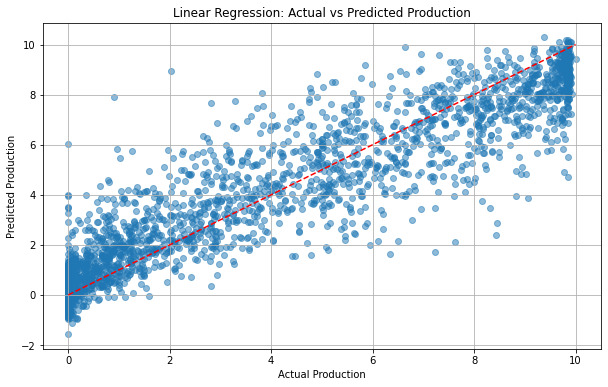

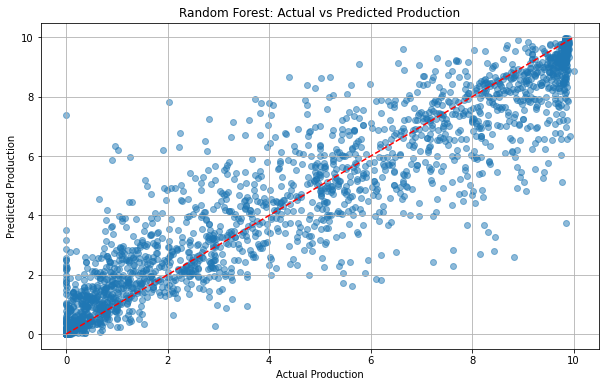

In [14]:
# Scatter plot of predicted vs actual values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Linear Regression: Actual vs Predicted Production')
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Random Forest: Actual vs Predicted Production')
plt.grid(True)
plt.show()

Until here, the regular Linear Regression and Random Forest Models are explained and compared. However, in order to find the best model for forecasting, some improvements are needed. In the code block below, the models are retrained by adding new features. The squares of some of the predictors are added to the model in case there may be a relationship with their squares. 

In [15]:
# Iterative Model Improvement
# Adding new features and retraining
def add_features(data):

    for column in data.columns:
        if 'dswrf_surface' in column or 'tmp_surface' in column:
            data[f'{column}_sq'] = data[column] ** 2
    return data

data = add_features(data)

After the data has been renewed with new features, it is divided into two parts: training and test sets.

In [16]:
# Splitting the new dataset
X = data.drop(columns=['production'])
y = data['production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [17]:
# Retrain models with new features
lr_model.fit(X_train, y_train)
lr_predictions_new = lr_model.predict(X_test)

rf_model.fit(X_train, y_train)
rf_predictions_new = rf_model.predict(X_test)

In the code block below, renewed Linear Regression and Random Forest models are compared against each other using MAPE. As before, the MAPE of the Random Forest Model is less than the MAPE of the Linear Regression Model. When the new versions of models are compared against the regular models that are explained before, it is observed that the smallest MAPE of all four models is the New Random Forest Model and the highest MAPE belongs to the New Linear Regression Model.

In [18]:
# Evaluation of new models
lr_mape_new = mean_absolute_percentage_error(y_test, lr_predictions_new)
rf_mape_new = mean_absolute_percentage_error(y_test, rf_predictions_new)

# Print new MAPE values
print(f"New Linear Regression MAPE: {lr_mape_new}")
print(f"New Random Forest MAPE: {rf_mape_new}")


New Linear Regression MAPE: 652102963171526.5
New Random Forest MAPE: 63087773485335.37


For the project, the forecasts for each hour of the day are needed. Therefore, using the Linear Regression and Random Forest models, hourly predictions are generated. The actual observations and their corresponding forecasts from the models are represented by 24 graphs below.

Between hours 17 and 6, the sun is not as high as it is in other hours. In the graphs, from hour 6 to hour 17, the predictions from both models seem aligned with the actual observations. However, when hour 17 and after are considered, it is seen that the random forecast produces more meaningful forecasts. In the night, the Linear Regression Model produces forecasts that indicate there will be a production; however, that is impossible. So, even though the Linear Regression Model could be utilized for predictions of midday, it should not be used for other times.

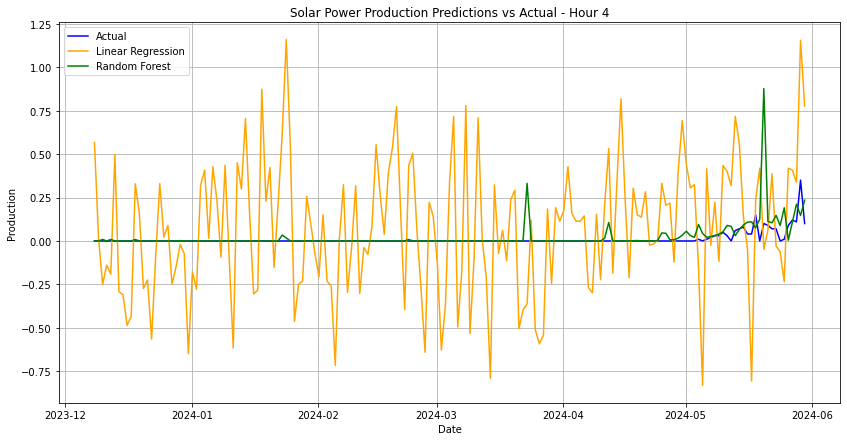

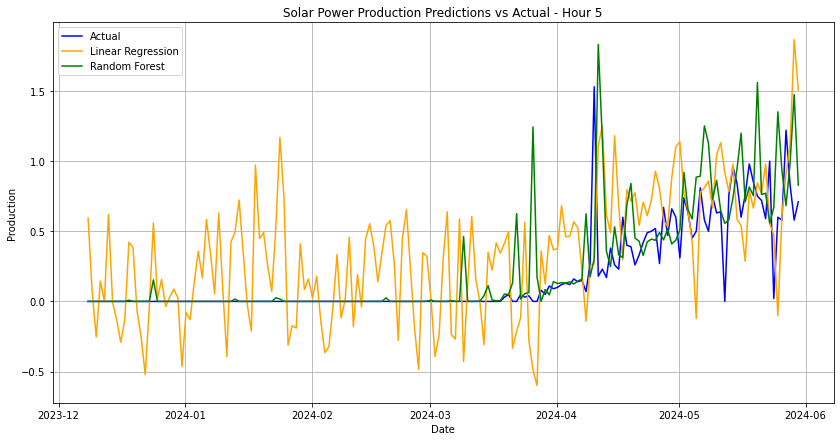

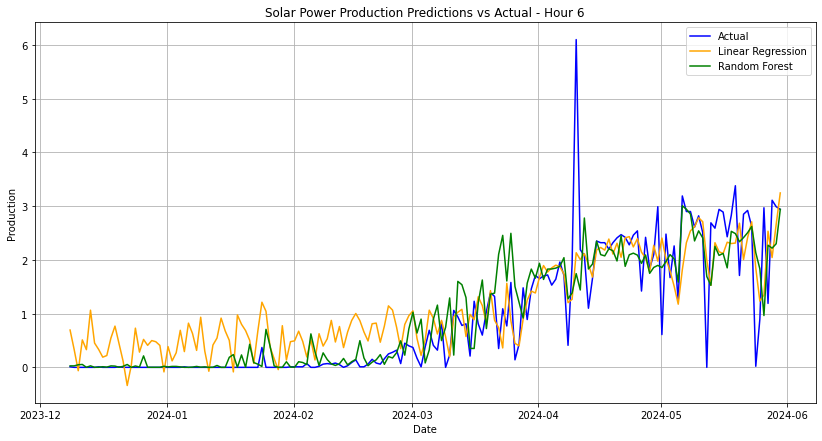

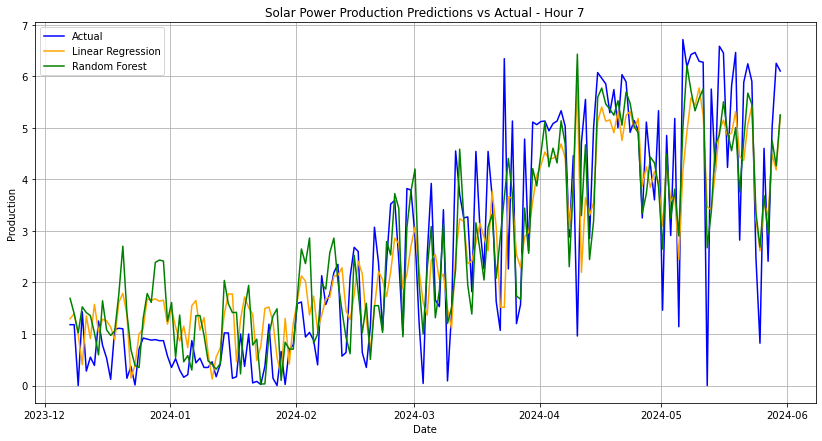

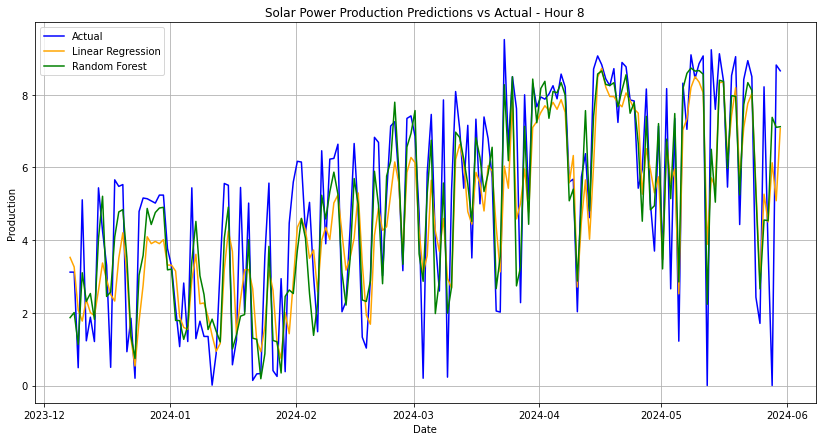

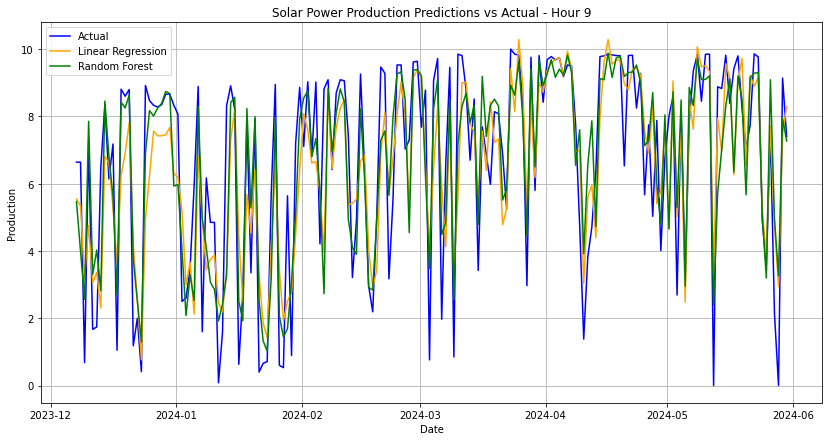

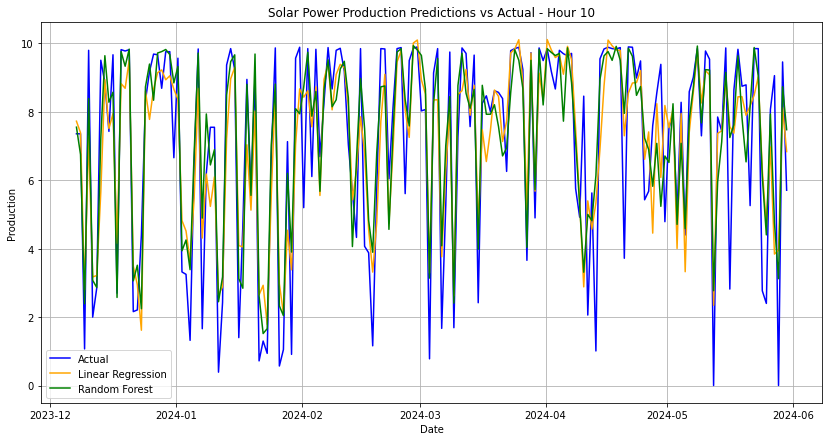

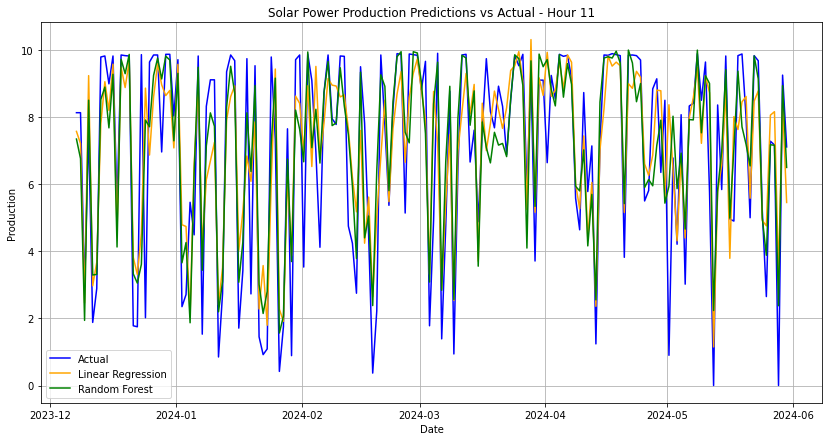

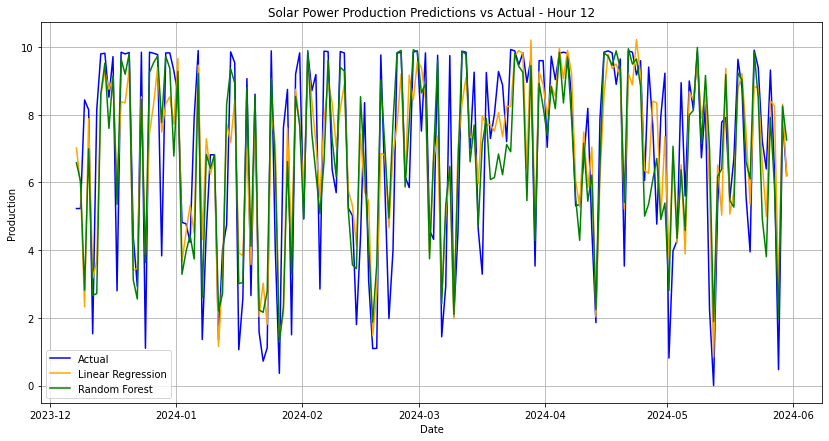

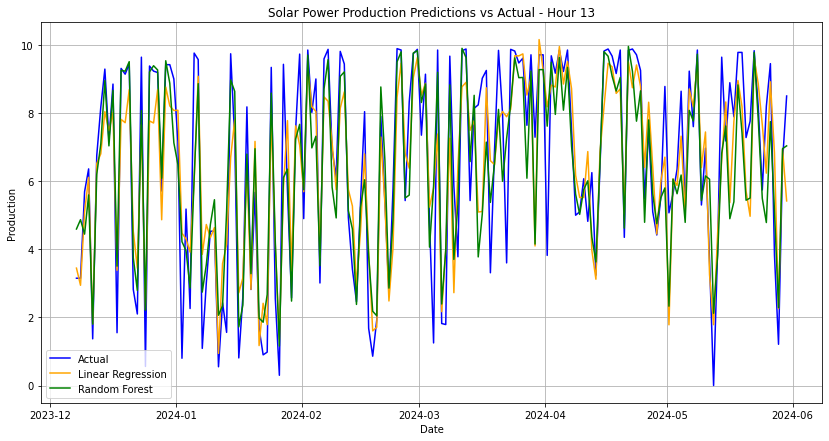

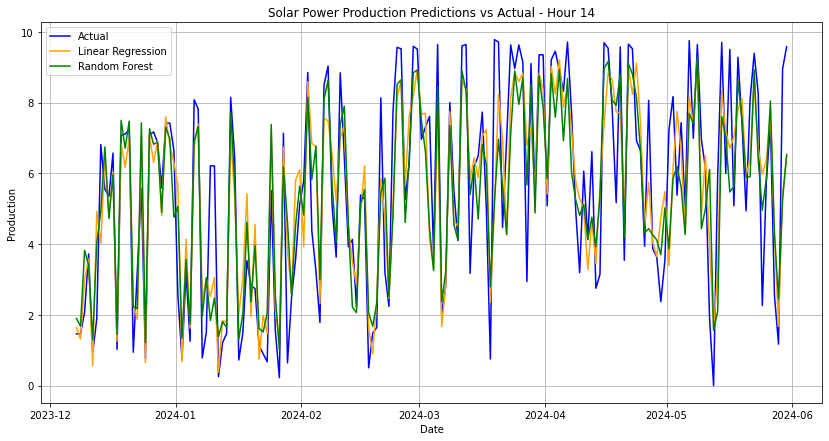

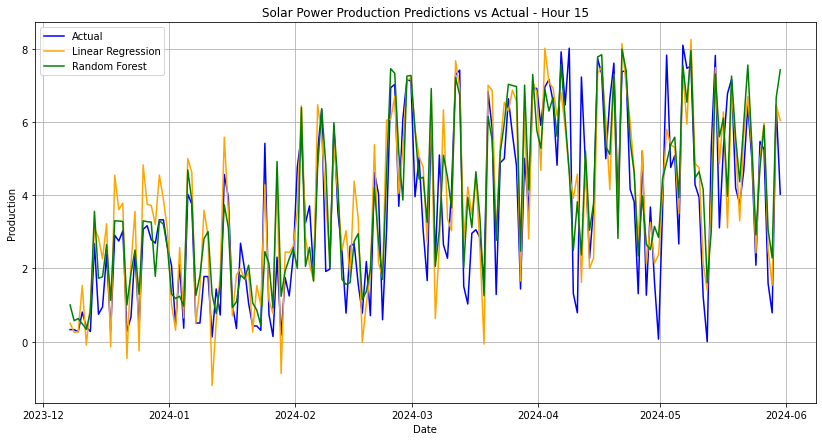

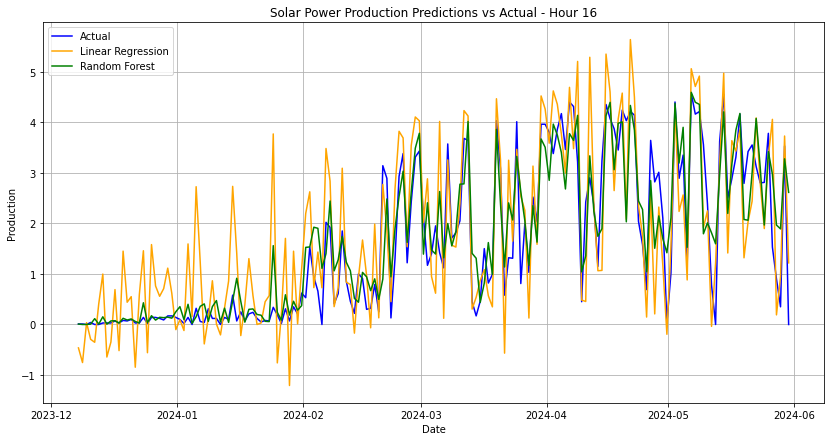

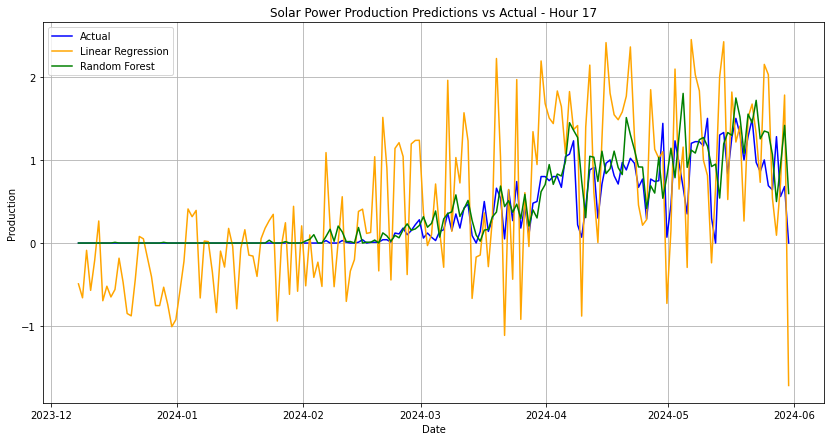

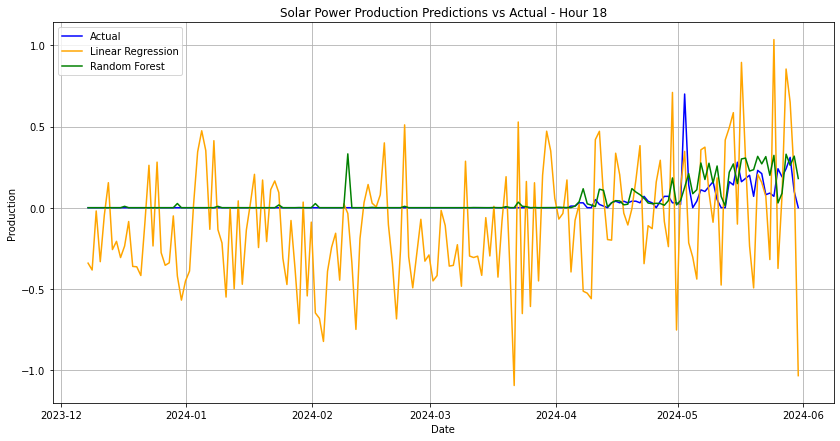

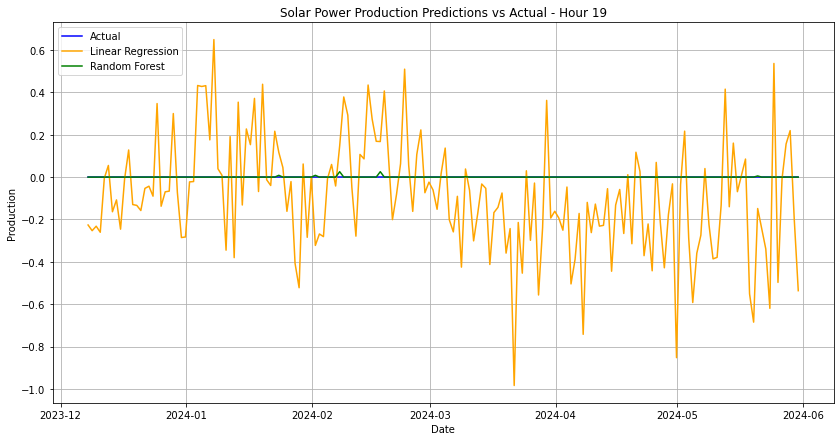

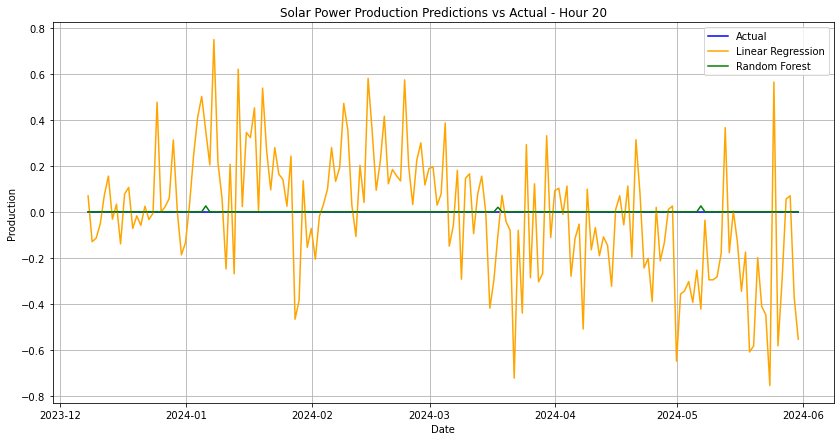

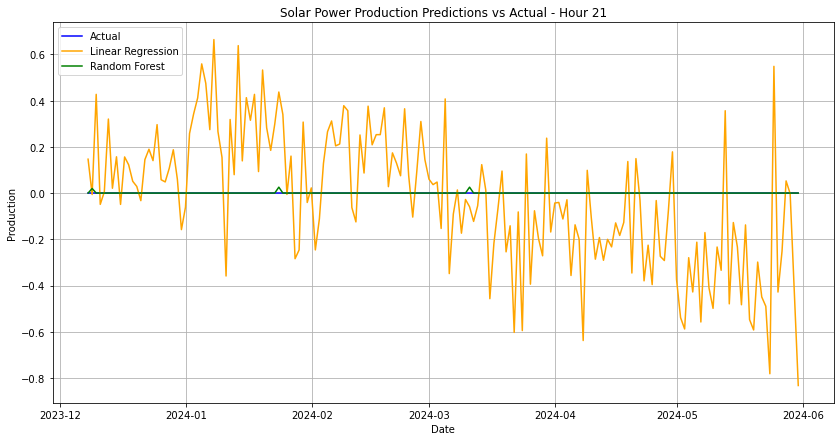

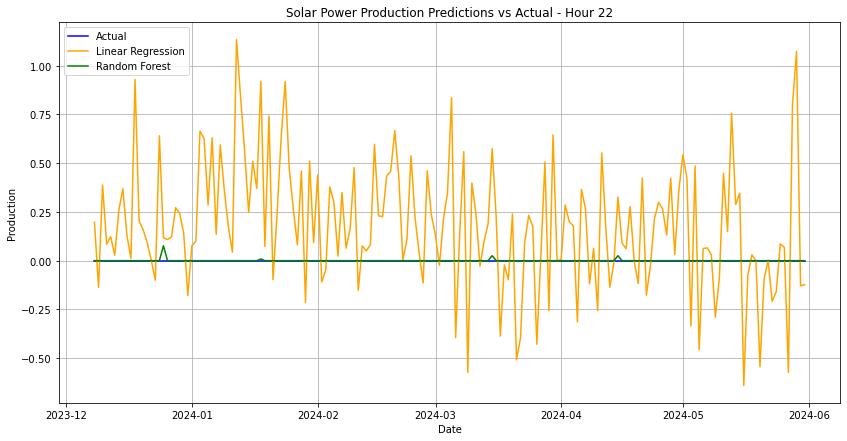

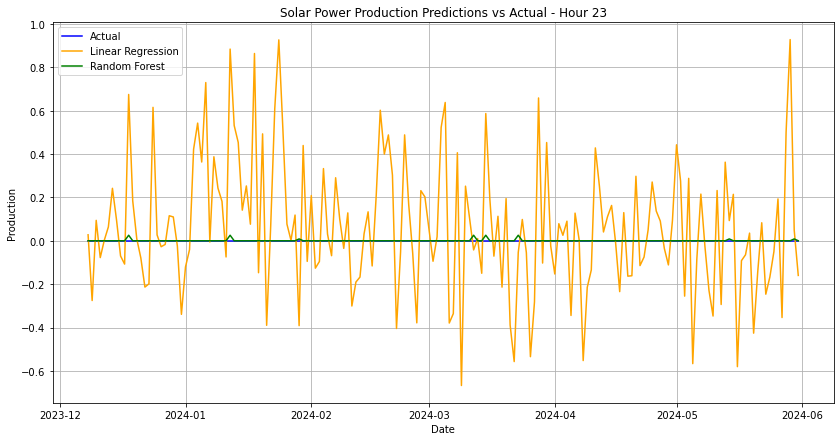

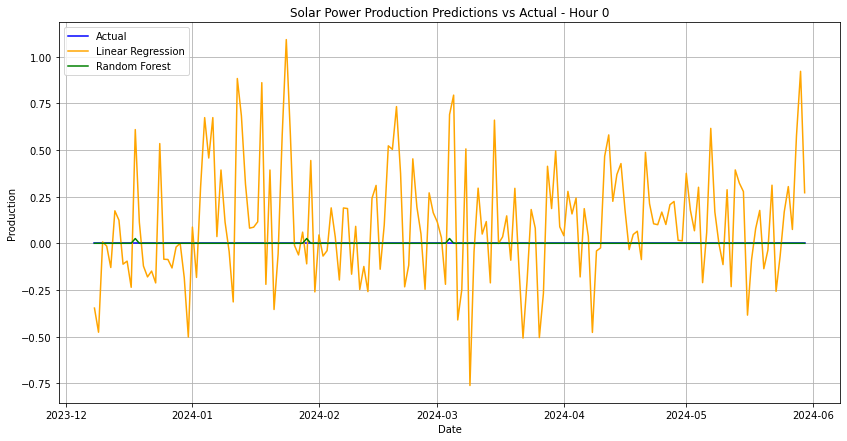

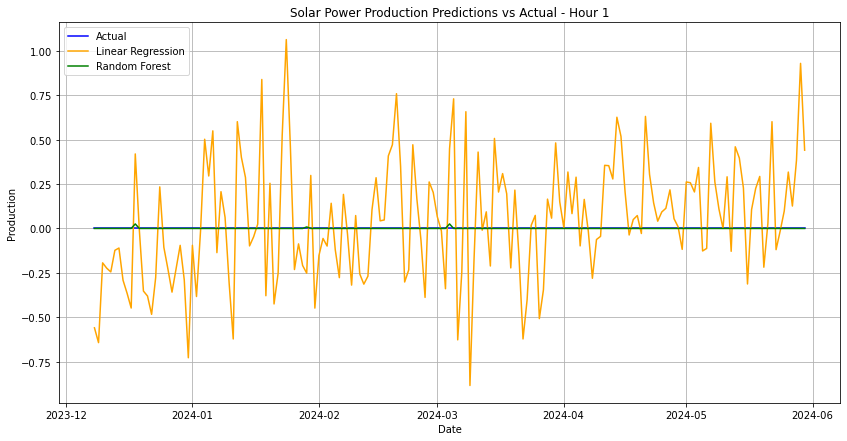

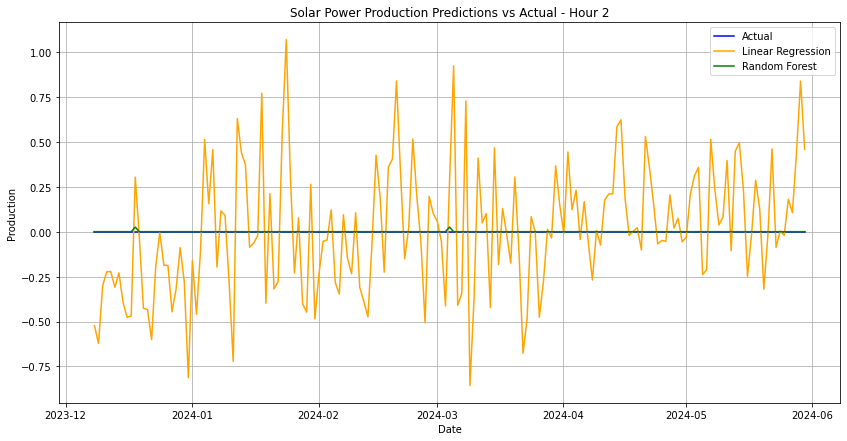

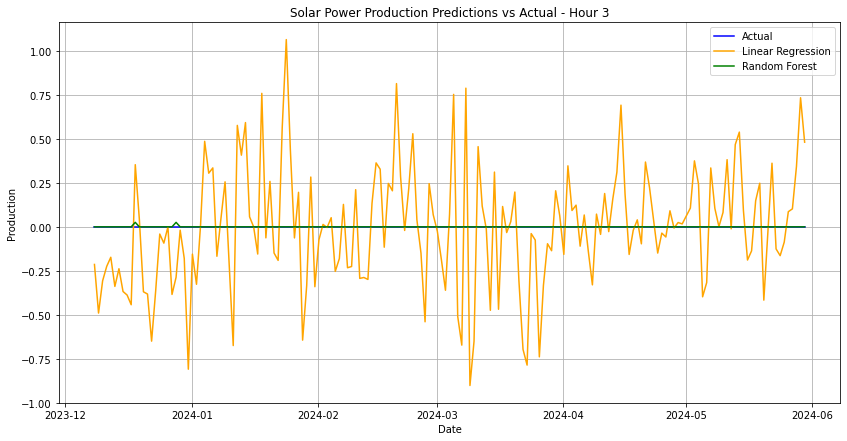

In [19]:
# Prediction-Actual graph for 24 hours one by one
hours = datetime_index.dt.hour.unique()
for hour in hours:
    mask = datetime_index.iloc[-len(y_test):].dt.hour == hour
    plt.figure(figsize=(14, 7))
    plt.plot(datetime_index.iloc[-len(y_test):][mask], 
             y_test[mask], label='Actual', color='blue')
    plt.plot(datetime_index.iloc[-len(y_test):][mask], 
             lr_predictions_new[mask], label='Linear Regression', color='orange')
    plt.plot(datetime_index.iloc[-len(y_test):][mask], 
             rf_predictions_new[mask], label='Random Forest', color='green')
    plt.xlabel('Date')
    plt.ylabel('Production')
    plt.title(f'Solar Power Production Predictions vs Actual - Hour {hour}')
    plt.legend()
    plt.grid(True)
    plt.show()

In the code block below, first, the rows that have missing data are dropped. Then, the sample size is decreased to create a subset. As done before, the subset is divided into training and test sets.

In [21]:
# Drop rows with missing values
data.dropna(inplace=True)

# Subset the data for quicker experimentation and reduced memory usage
data_subset = data.sample(n=300, random_state=42)  # Further reduce sample size
X = data_subset.drop(columns=['production'])
y = data_subset['production']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Below, the "add polynomial features" function is used. The function is used to handle the nonlinear relationships between the predictor and forecast variables of the model. Specification of "degree=2" in the code indicates that it seeks not only the squared relation but also all combinations up to the second degree. Another advantage of this function is that it handles the missing values by filling NaNs with 0.

In [22]:
# Function to add polynomial features and handle NaNs
def add_polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))
    return X_poly_df.fillna(0)  # Fill NaNs with 0


In [23]:
# Add polynomial features with a lower degree
X_train_poly = add_polynomial_features(pd.DataFrame(X_train_scaled, columns=X_train.columns), degree=2)
X_test_poly = add_polynomial_features(pd.DataFrame(X_test_scaled, columns=X_test.columns), degree=2)


/Users/ahmetemregokalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ahmetemregokalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In the code below, the rf stands for Random Forest and gb is used for Gradient Boosting. For these machiene learning models, the parameters are specified.

Gradient Boosting is a method that is used for regression purposes. It uses decision trees as Random Forest does. Whether Random Forest or Gradient Boosting works better depends on the data at hand. Gradient boosting has some advantages compared to Random Forest. For instance, it uses residuals and gradient descent to optimize the model and it uses fewer trees. However, it could be slower and more sensitive to outliers.

In [24]:
# Clear unnecessary objects from memory
del data, data_subset, X, y, X_train, X_test, X_train_scaled, X_test_scaled
gc.collect()


# Hyperparameter tuning with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [10, 50],
    'max_depth': [3, 5]
}
param_dist_gb = {
    'n_estimators': [10, 50],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}


In [25]:
# Perform Randomized Search for Random Forest
random_search_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist_rf, 
                                      n_iter=5, cv=2, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train_poly, y_train)
best_rf = random_search_rf.best_estimator_
print(f"Best Random Forest parameters: {random_search_rf.best_params_}")


/Users/ahmetemregokalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Random Forest parameters: {'n_estimators': 50, 'max_depth': 5}


In [26]:
# Perform Randomized Search for Gradient Boosting
random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions=param_dist_gb, 
                                      n_iter=5, cv=2, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, random_state=42)
random_search_gb.fit(X_train_poly, y_train)
best_gb = random_search_gb.best_estimator_
print(f"Best Gradient Boosting parameters: {random_search_gb.best_params_}")



Best Gradient Boosting parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


So far, Linear Regression, Ridge Regression, Lasso Regression, Random Forest and Gradient Boosting models are considered as possible forecast models.

Ridge Regression, known as L2 regularization, is a kind of regularization of Linear Regression. It reduces the errors that overfitting may generate and especially works to reduce the multicollinearity of the predictor variables. In the project, there are lots of different possible predictor variables, so it is highly important to handle multicollinearity. In the code, its parameter alpha is set to 1. The alpha in Ridge Regression works to penalize the model for an increase in the coefficient size. 

Lasso Regression, known as L1 regularization, is another kind of regularization of Linear Regression. It tries to increase the accuracy of the model by penalizing overfitting. It also has a coefficient alpha. However, in Lasso, there is a possibility that as the alpha increases the model gets so simpler that it cannot reflect the pattern of the data. Even though the Ridge Regression may diminish the coefficients, it does not make them 0, but the Lasso Regression may do.

In [27]:
# Models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb
}


MAPE values of models are presented below. According to the MAPE values, the forecasting accuracies of the models could be sorted from highest accuracy to lowest as Gradient Boosting, Random Forest, Lasso Regression, Ridge Regression, and Linear Regression.

In [40]:
# Train and evaluate models
results = {}
predictions_dict = {}
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    predictions = model.predict(X_test_poly)
    mape = mean_absolute_percentage_error(y_test, predictions)
    results[name] = mape
    predictions_dict[name] = predictions
    print(f"{name} MAPE: {mape}")


Linear Regression MAPE: 3262403718088397.0
Ridge Regression MAPE: 3260434192887331.0
Lasso Regression MAPE: 835877617740163.5
Random Forest MAPE: 706169581346050.2
Gradient Boosting MAPE: 412564591934531.06


In order to compare the model accuracy, the following MAPE versus Model graph could be observed.

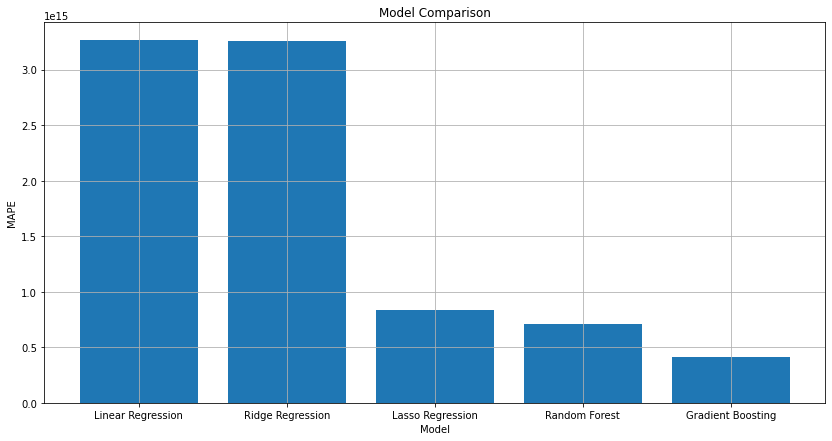

In [41]:
# Plot results
plt.figure(figsize=(14, 7))
plt.bar(results.keys(), results.values())
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Model Comparison')
plt.grid(True)
plt.show()


The following code block selects the best model as the one having minimum MAPE, which is Gradient boosting. Then, the actual hourly production values and their corresponding forecasts that are made by the Gradient Boosting Model are compared in graphs. Also, for visual comparison, the Linear Regression and Random Forest forecasts are implemented in the graphs.

In [42]:
# Best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# Prediction-Actual graph for 24 hours one by one using the best model
best_model.fit(X_train_poly, y_train)
best_predictions = best_model.predict(X_test_poly)


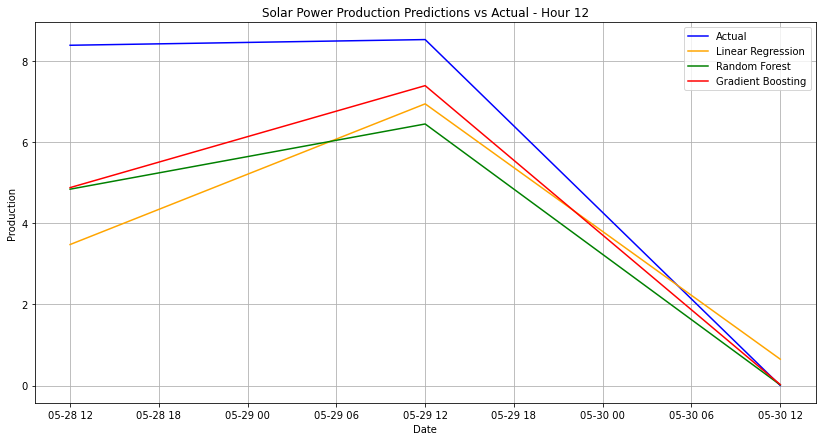

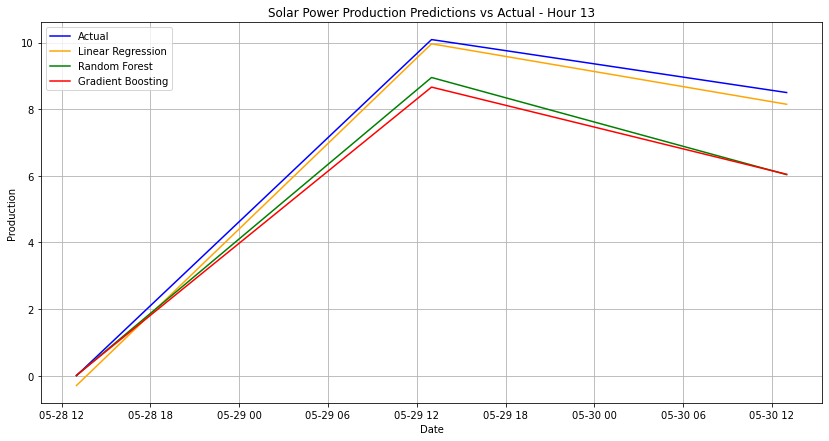

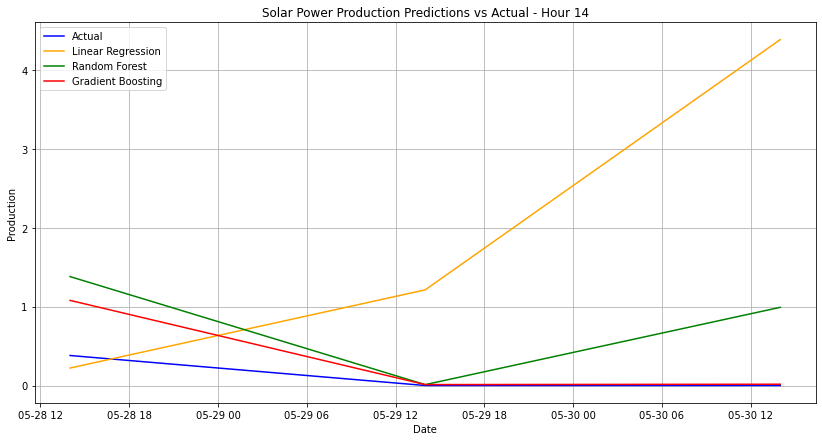

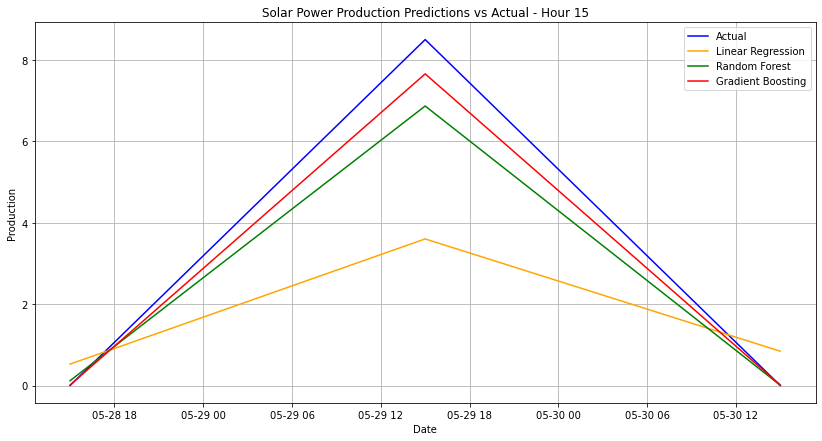

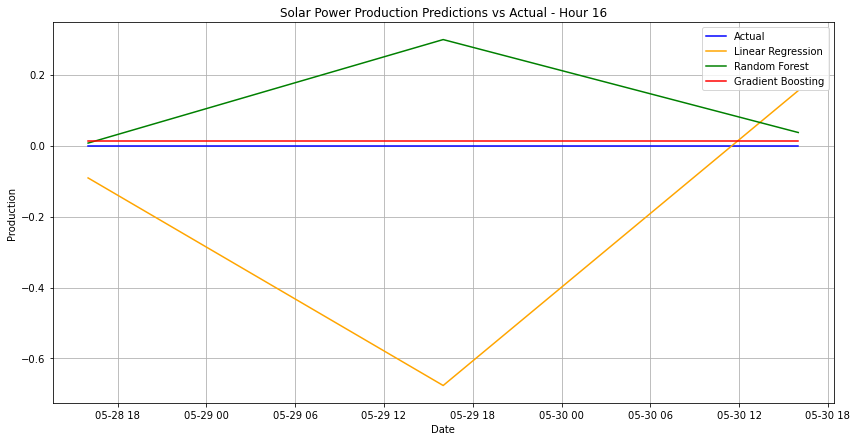

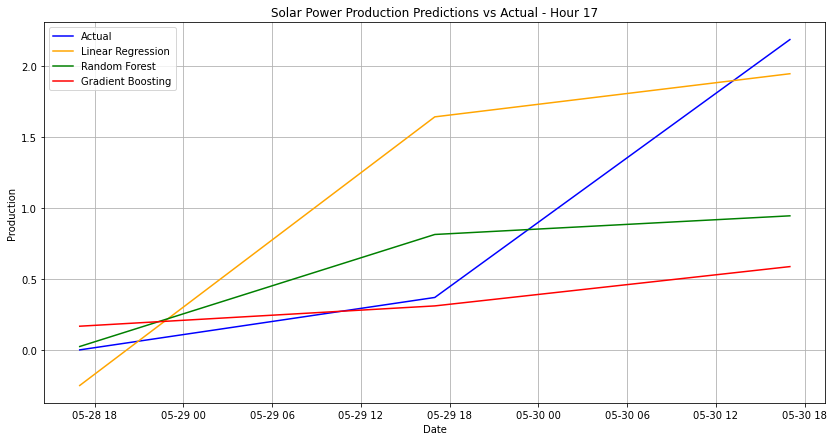

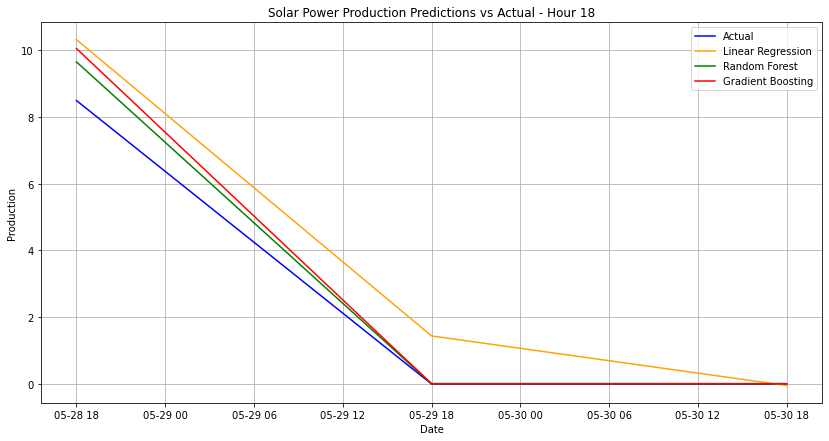

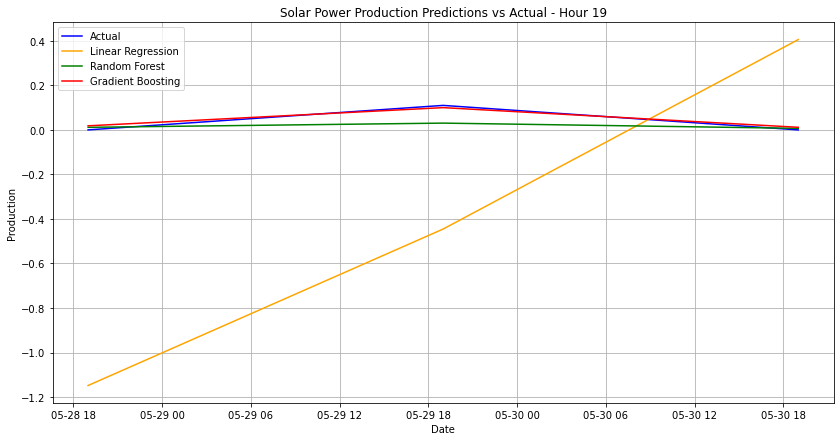

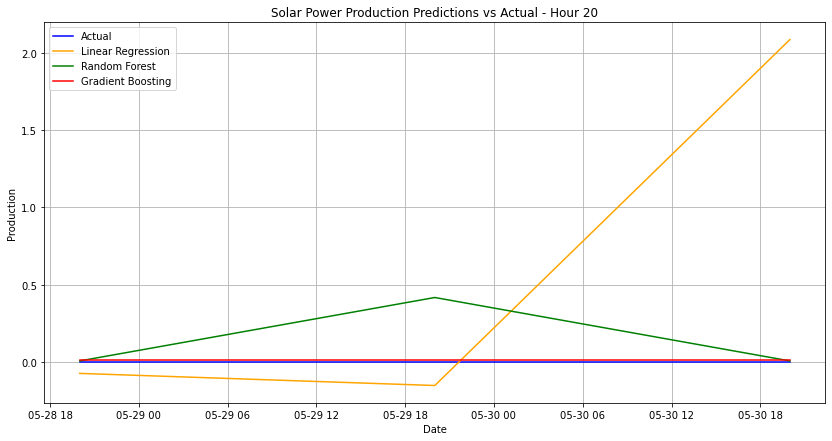

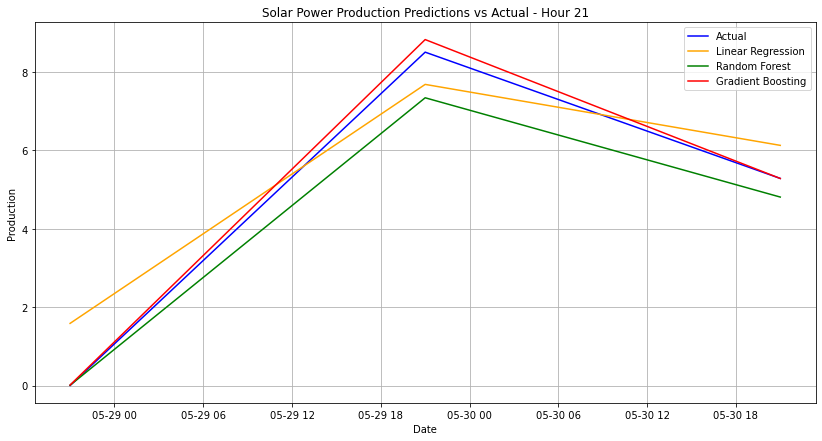

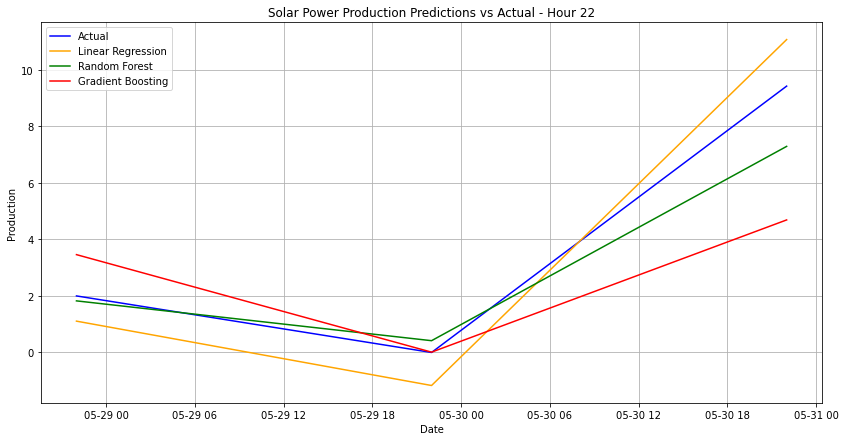

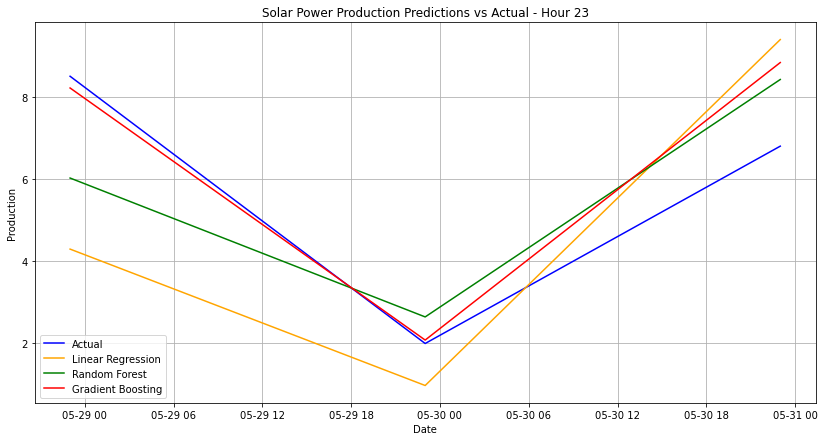

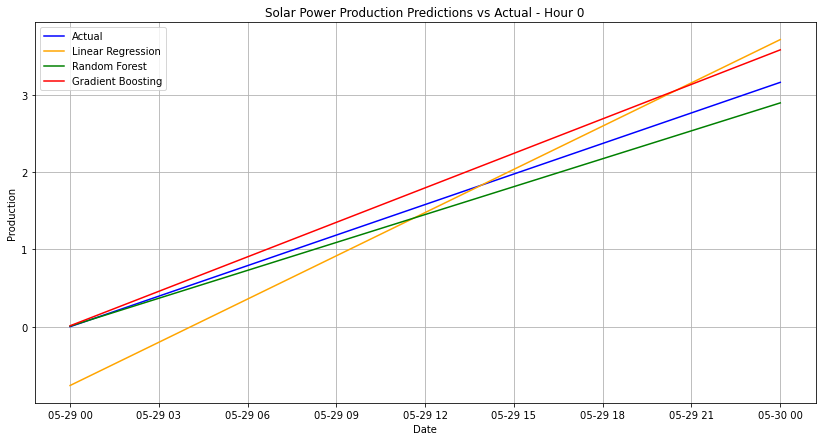

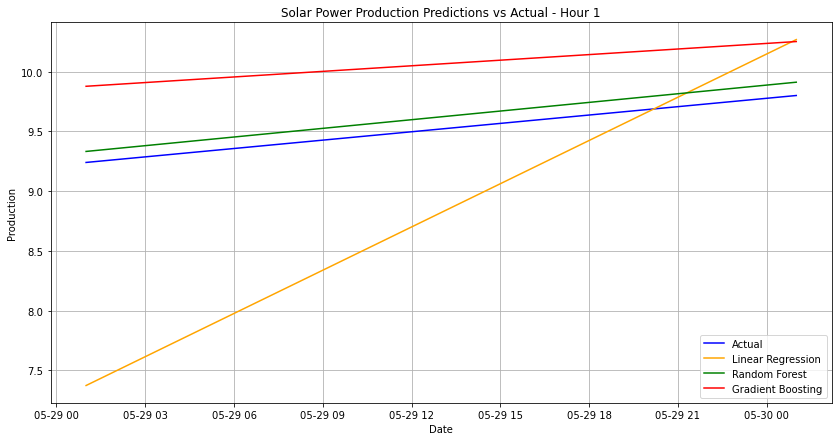

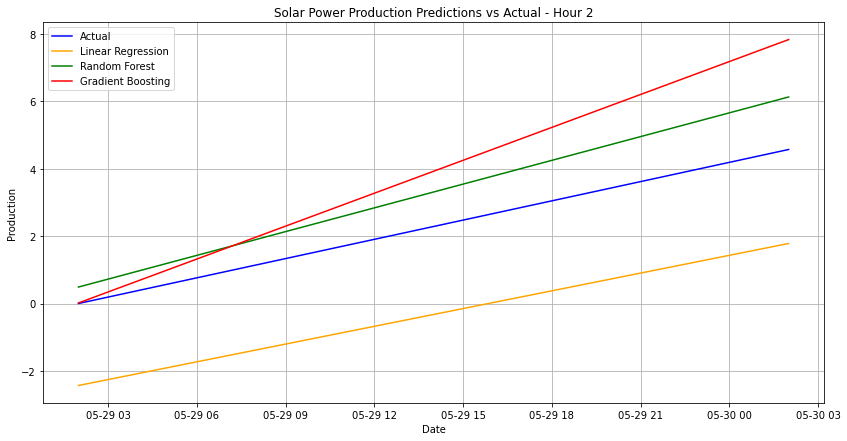

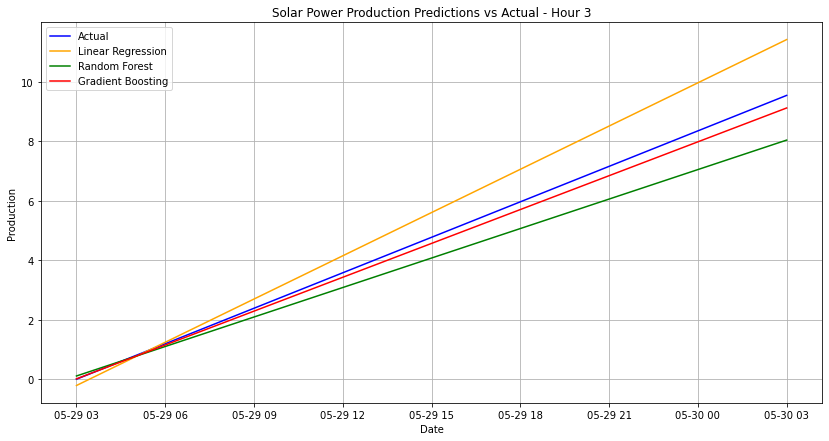

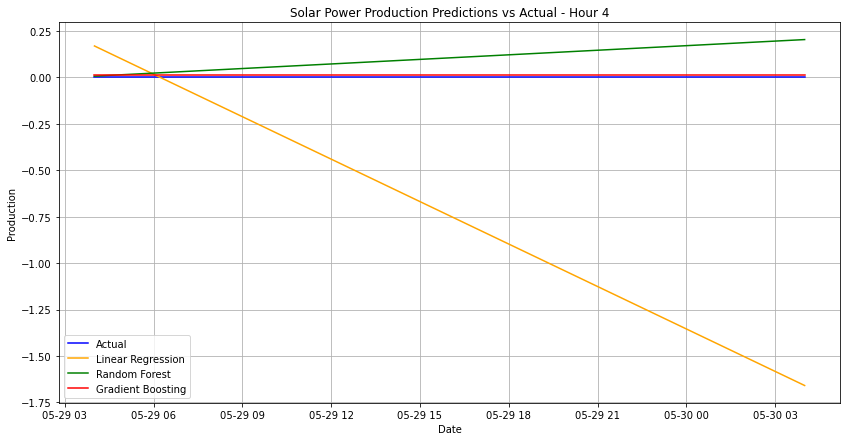

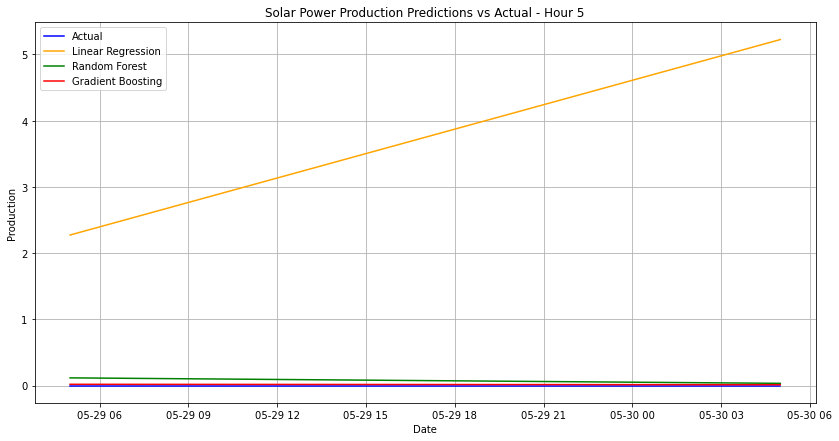

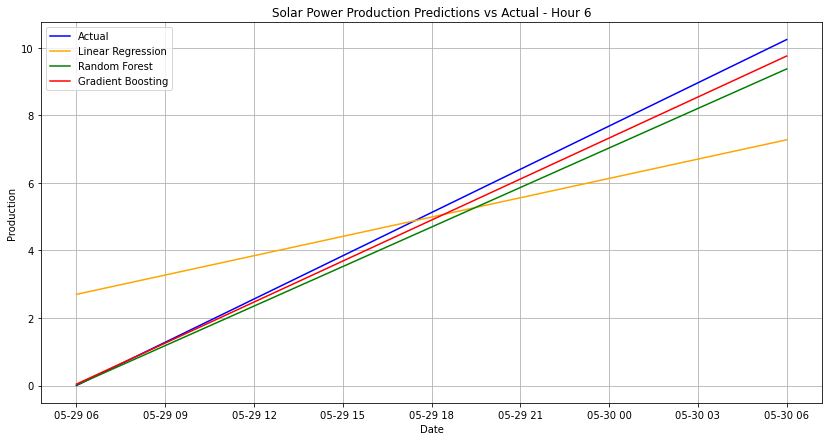

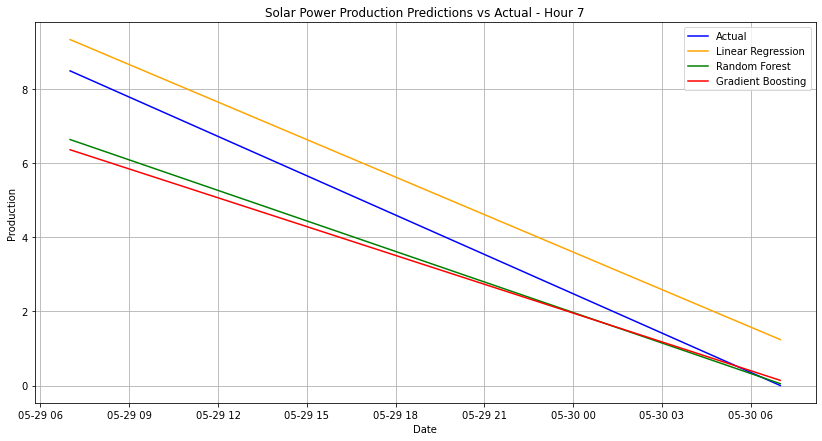

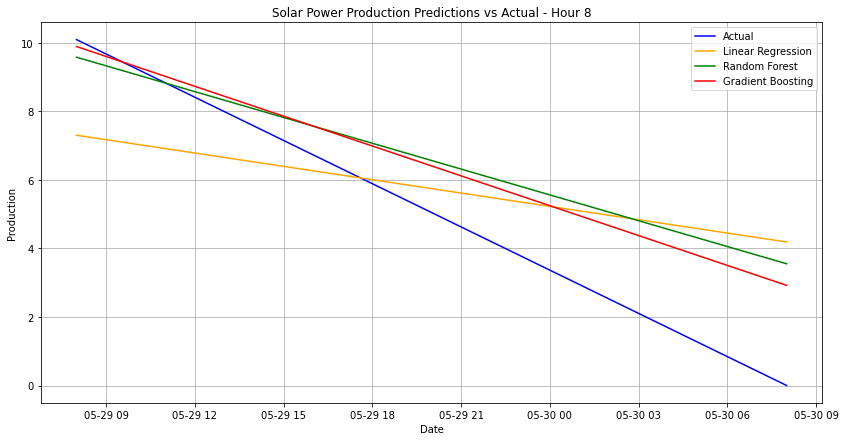

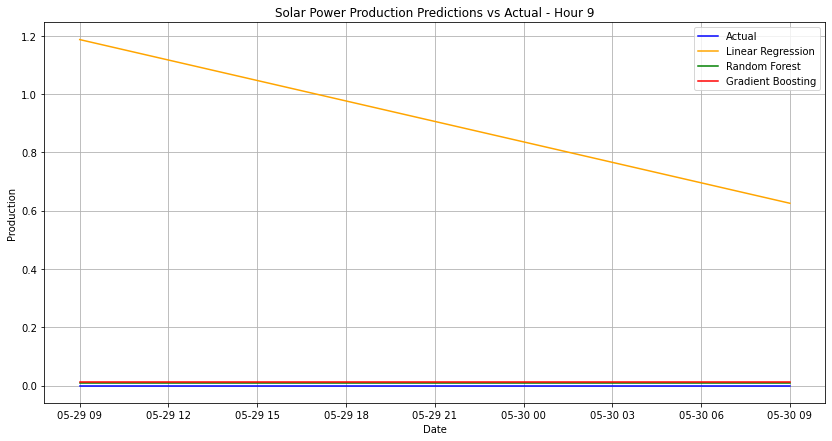

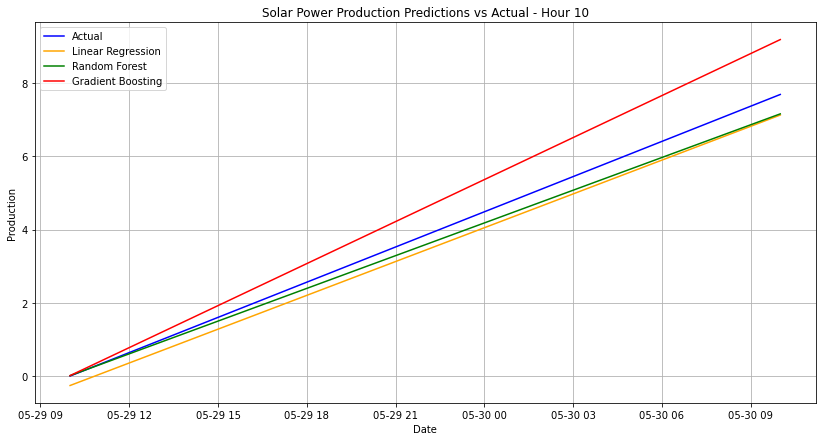

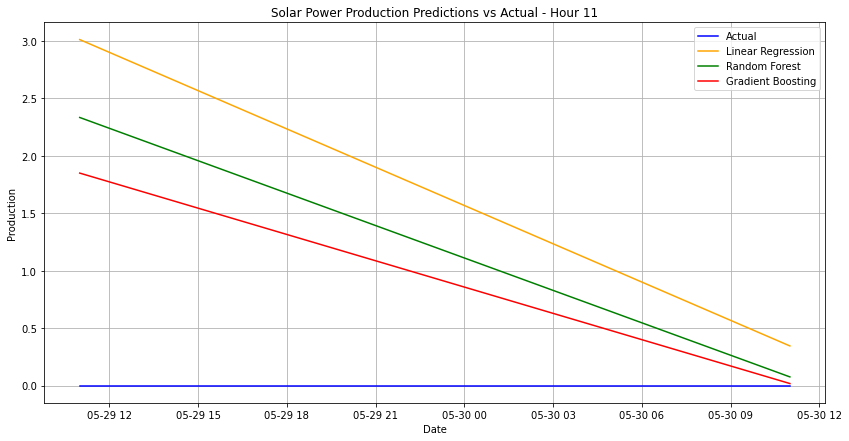

In [50]:
# Ensure datetime index is correctly aligned with y_test
datetime_test = datetime_index.iloc[-len(y_test):]

# Create plots for each hour including all days with Gradient Boosting
hours = datetime_test.dt.hour.unique()
for hour in hours:
    plt.figure(figsize=(14, 7))
    mask = datetime_test.dt.hour == hour
    mask_indices = np.where(mask)[0]  # Get the indices where mask is True
    plt.plot(datetime_test.iloc[mask_indices], y_test.iloc[mask_indices], label='Actual', color='blue')
    plt.plot(datetime_test.iloc[mask_indices], predictions_dict['Linear Regression'][mask_indices], label='Linear Regression', color='orange')
    plt.plot(datetime_test.iloc[mask_indices], predictions_dict['Random Forest'][mask_indices], label='Random Forest', color='green')
    plt.plot(datetime_test.iloc[mask_indices], predictions_dict['Gradient Boosting'][mask_indices], label='Gradient Boosting', color='red')
    plt.xlabel('Date')
    plt.ylabel('Production')
    plt.title(f'Solar Power Production Predictions vs Actual - Hour {hour}')
    plt.legend()
    plt.grid(True)
    plt.show()

RESULTS AND DISCUSSION

Finally, the Gradient Boosting model is constructed again with the training data set. Then, the actual production values and their corresponding forecasts by the Gradient Boosting throughout the project term are compared. As one can see via the graphs, the model is highly aligned with the solar power production observations.

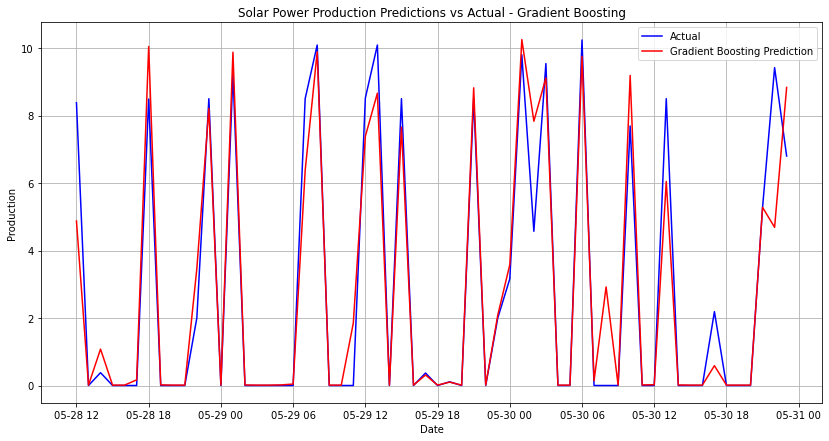

In [51]:
# Train Gradient Boosting model
best_gb.fit(X_train_poly, y_train)
gb_predictions = best_gb.predict(X_test_poly)

# Ensure datetime index is correctly aligned with y_test
datetime_test = datetime_index.iloc[-len(y_test):]

# Plot Gradient Boosting predictions vs actuals for all hours and all days
plt.figure(figsize=(14, 7))
plt.plot(datetime_test, y_test, label='Actual', color='blue')
plt.plot(datetime_test, gb_predictions, label='Gradient Boosting Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Solar Power Production Predictions vs Actual - Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()

CONCLUSIONS AND FUTURE WORK

In conclusion, 5 different models (Gradient Boosting, Random Forest, Lasso Regression, Ridge Regression, and Linear Regression) are used in the project to determine which one of them is better to forecast the hourly solar power production of the Edikli GES for the next day. Using the Mean Absolute Percentage Error (MAPE) measure, the Gradient Boosting Model is found best. The final forecasts obtained from this model and the actual production values of the Edikli GES seem very similar to each other, as shown in the graphs.

In the project, the ARIMA (Autoregressive Integrated Moving Average) Model is not utilized. Since a seasonal or non-seasonal ARIMA is not constructed for forecasting, there is no need to make the data stationary. Therefore, the differencing in data is not implemented through the model selection. As a future work, ARIMA and SARIMA models can be used as another approach and their accuracy could be compared with the 5 methods used in this project.

REFERENCES

[1] What is a solar power plant? How it works and types. (2023, September 11). REPSOL. https://www.repsol.com/en/energy-and-the-future/future-of-the-world/solar-power-plant/index.cshtml

[2] What is solar power forecasting? – gridX. (n.d.). https://www.gridx.ai/knowledge/what-is-solar-power-forecasting#:~:text=Physical%20solar%20forecasting%20is%20a,forecasts%20of%20photovoltaic%20energy%20output

[3] Gautier, C., Diak, G., & Masse, S. (1980, August). A Simple Physical Model to Estimate Incident Solar Radiation at the Surface from GOES Satellite Data. Journal of Applied Meteorology, 19(8), 1005–1012. http://dx.doi.org/10.1175/1520-0450(1980)019<1005:aspmte>2.0.co;2

[4] K., D., & I, I. (2016, July 15). Solar Power Forecasting: A Review. International Journal of Computer Applications, 145(6), 28–50. https://doi.org/10.5120/ijca2016910728

[5] Atique, S., Noureen, S., Roy, V., Subburaj, V., Bayne, S., & Macfie, J. (2019, January). Forecasting of total daily solar energy generation using ARIMA: A case study. 2019 IEEE 9th Annual Computing and Communication Workshop and Conference (CCWC). https://doi.org/10.1109/ccwc.2019.8666481

[6] Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 05.06.2024.